# Cancer Classification
The dataset has cancer classified as Benign or Malignant. Let's try and build a model which will validate this classification and can be used to test additional records

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # for any linear algrebraic equations
# keeps the plots in one place. calls image as static pngs
%matplotlib inline 
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
#import mpld3 as mpl

#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

In [2]:
import os
os.chdir("E:\python")

In [3]:
#Reading the cancer dataset
cancer = pd.read_csv("data.csv",header = 0)
cancer.head()
#Let's drop the two irrelevant columns which will not be helpful
cancer.drop('id',axis=1,inplace=True)
cancer.drop('Unnamed: 32',axis=1,inplace=True)

Let's map the diagnosis column values of 'M' malign and 'B' benignant tumor to an integer value

In [4]:

cancer['diagnosis'] = cancer['diagnosis'].map({'M':1,'B':0})
cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


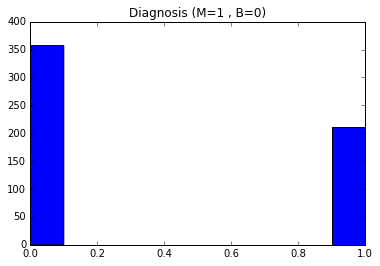

In [5]:
#cancer.describe()
#Let's view a histogram of the Diagnosis column
plt.hist(cancer['diagnosis'])
# Let's plot the Diagnosis distribution
plt.title('Diagnosis (M=1 , B=0)')
plt.show()

In [6]:
features_mean=list(cancer.columns[1:11]) #selecting columns relevant to us for feature selection
# split dataframe into two based on diagnosis
cancerM=cancer[cancer['diagnosis'] ==1]
cancerB=cancer[cancer['diagnosis'] ==0]

In [7]:
train=cancer[:400]
test=cancer[400:]

In [8]:
#defining a function which will help in classification
def classification_model(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors],data[outcome])
  
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
  
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
    # Filter training data
        train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    
        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

In [9]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean']
outcome_var='diagnosis'
model=LogisticRegression()
classification_model(model,train,predictor_var,outcome_var)

Accuracy : 89.250%
Cross-Validation Score : 76.250%
Cross-Validation Score : 81.250%
Cross-Validation Score : 84.167%
Cross-Validation Score : 86.875%
Cross-Validation Score : 88.000%


In [10]:
# Use all the features of the nucleus
predictor_var = features_mean
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, train,predictor_var,outcome_var)

Accuracy : 95.000%
Cross-Validation Score : 85.000%
Cross-Validation Score : 85.000%
Cross-Validation Score : 88.333%
Cross-Validation Score : 90.312%
Cross-Validation Score : 91.500%


In [11]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

concave points_mean       0.207431
concavity_mean            0.196854
area_mean                 0.176073
perimeter_mean            0.146349
radius_mean               0.113204
compactness_mean          0.056836
texture_mean              0.046912
smoothness_mean           0.029887
symmetry_mean             0.016207
fractal_dimension_mean    0.010248
dtype: float64


In [12]:
# Using top 5 features
predictor_var = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean',]
model = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(model,train,predictor_var,outcome_var)

Accuracy : 94.000%
Cross-Validation Score : 83.750%
Cross-Validation Score : 84.375%
Cross-Validation Score : 88.333%
Cross-Validation Score : 90.312%
Cross-Validation Score : 91.000%


In [13]:
# Use all the features of the nucleus
predictor_var = features_mean
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, test,predictor_var,outcome_var)

Accuracy : 97.633%
Cross-Validation Score : 94.118%
Cross-Validation Score : 95.588%
Cross-Validation Score : 94.118%
Cross-Validation Score : 94.118%
Cross-Validation Score : 94.688%


Thus with such a high accuracy we will be using the Random Forest model for all testing purposes